# Natural Language Processing with Disaster Tweets

[](https://www.kaggle.com/c/nlp-getting-started/data?select=train.csv)

In [1]:
import tensorflow as tf

keras = tf.keras

tf.__version__

'2.5.0'

# Prepare Data

In [59]:
import pandas as pd

train_data = pd.read_csv('../input/nlp-getting-started/train.csv')
print(len(train_data))
train_data.head(5)

7613


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [58]:
test_data = pd.read_csv('../input/nlp-getting-started/test.csv')
print(len(test_data))
test_data.head(5)

3263


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [105]:
sample_submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
sample_submission.head(5)

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [9]:
train_texts = train_data.text.to_numpy()
train_targets = train_data.target.to_numpy()

test_texts = test_data.text.to_numpy()
test_ids = test_data.id.to_numpy()

In [60]:
vocab_size = 7000

In [61]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = vocab_size, oov_token = '<OOV>')
tokenizer.fit_on_texts(train_texts)
word_index = tokenizer.word_index
for index, (text, text_index) in enumerate(word_index.items()):
    if index >= 5:
        break
    print(text, text_index)

<OOV> 1
t 2
co 3
http 4
the 5


In [62]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [63]:
for index, text in enumerate(train_texts):
    if index >= 5:
        break
    print(text)
    print(tokenizer.texts_to_sequences([text]))

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
[[120, 4634, 25, 5, 869, 9, 22, 264, 139, 1620, 4635, 90, 41]]
Forest fire near La Ronge Sask. Canada
[[190, 46, 230, 800, 6955, 6956, 1405]]
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
[[41, 1752, 1621, 8, 6957, 7, 6958, 25, 137, 6959, 21, 1753, 40, 442, 257, 58, 2159, 7, 715, 1406, 25, 1107]]
13,000 people receive #wildfires evacuation orders in California 
[[836, 2922, 60, 4636, 1501, 257, 1406, 7, 97]]
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
[[35, 101, 1222, 22, 321, 23, 6960, 2160, 31, 272, 23, 1501, 6961, 70, 6, 188]]


In [64]:
for index, text in enumerate(test_texts):
    if index >= 5:
        break
    print(text)
    print(tokenizer.texts_to_sequences([text]))
    

Just happened a terrible car crash
[[35, 914, 6, 1952, 131, 93]]
Heard about #earthquake is different cities, stay safe everyone.
[[475, 57, 264, 12, 1202, 2649, 606, 2322, 246]]
there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all
[[78, 12, 6, 190, 46, 20, 826, 3576, 1, 25, 5168, 872, 5, 770, 11, 1415, 506, 98, 41]]
Apocalypse lighting. #Spokane #wildfires
[[480, 3940, 1, 1501]]
Typhoon Soudelor kills 28 in China and Taiwan
[[218, 796, 478, 2565, 7, 943, 10, 1207]]


In [65]:
import numpy as np

sequences = tokenizer.texts_to_sequences(train_texts)
np.max(list(map(len, sequences)))

33

In [66]:
maxlen = 33

In [67]:
from keras.preprocessing.sequence import pad_sequences

def tokenize_and_pad_sequence(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(
        sequences,
        maxlen = maxlen,
        padding = 'post',
        truncating = 'post',
    )

train_sequences = tokenize_and_pad_sequence(train_texts)
test_sequences = tokenize_and_pad_sequence(test_texts)

# Build and Train Model

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_item(history_df, colname = 'loss', f = np.min, ax = None):
    val_colname = f'val_{colname}'
    print(f'{colname}: {f(history_df[colname]):.4f} - {val_colname}: {f(history_df[val_colname]):.4f}')
    history_df.loc[:, [colname, val_colname]].plot(title = colname.capitalize() , ax = ax)

def show_history(history):
    history_df = pd.DataFrame(history.history)
    
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
    plot_item(history_df, 'loss', ax = axes[0])
    plot_item(history_df, 'accuracy', ax = axes[1], f = np.max)

In [98]:
def fit_model(model, validation_split = 0.8, epochs = 500, patience = 5, verbose = 0):
    model.compile(
        optimizer = 'adam',
        loss = keras.losses.BinaryCrossentropy(from_logits = True),
        metrics = ['accuracy'],
    )

    early_stopping = keras.callbacks.EarlyStopping(
        patience = patience,
        restore_best_weights = True,
    )
    
    callbacks = [early_stopping]
    if validation_split == 0:
        callbacks = []

    history = model.fit(
        train_sequences, train_targets,
        validation_split = validation_split,
        epochs = epochs,
        callbacks = callbacks,
        verbose = verbose,
    )
    return history 

In [82]:
embedding_dim = 16

## DNN

In [91]:
tf.random.set_seed(1)
model_dnn = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length = maxlen),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(16, activation = 'relu'),
    keras.layers.Dense(1),
])
model_dnn.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 33, 16)            112000    
_________________________________________________________________
global_average_pooling1d_10  (None, 16)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 17        
Total params: 112,289
Trainable params: 112,289
Non-trainable params: 0
_________________________________________________________________


loss: 0.1512 - val_loss: 0.5598
accuracy: 0.9448 - val_accuracy: 0.7092


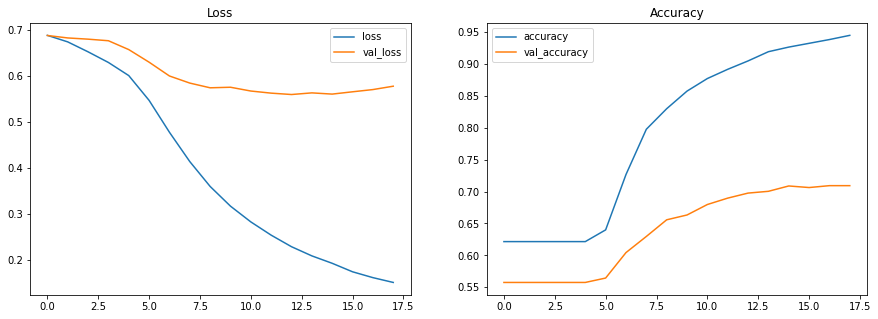

In [92]:
history_dnn = fit_model(model_dnn)
show_history(history_dnn)

## LTSM

In [93]:
tf.random.set_seed(1)
model_lstm_bi = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length = maxlen),
    keras.layers.Bidirectional(keras.layers.LSTM(embedding_dim)),
    keras.layers.Dense(16, activation = 'relu'),
    keras.layers.Dense(1),
])

model_lstm_bi.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 33, 16)            112000    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 32)                4224      
_________________________________________________________________
dense_32 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 17        
Total params: 116,769
Trainable params: 116,769
Non-trainable params: 0
_________________________________________________________________


Epoch 1/500
48/48 [==============================] - 4s 42ms/step - loss: 0.6768 - accuracy: 0.6216 - val_loss: 0.6889 - val_accuracy: 0.5575
Epoch 2/500
48/48 [==============================] - 1s 15ms/step - loss: 0.5960 - accuracy: 0.6229 - val_loss: 0.6229 - val_accuracy: 0.5577
Epoch 3/500
48/48 [==============================] - 1s 15ms/step - loss: 0.4011 - accuracy: 0.8049 - val_loss: 0.5654 - val_accuracy: 0.7104
Epoch 4/500
48/48 [==============================] - 1s 15ms/step - loss: 0.2478 - accuracy: 0.9028 - val_loss: 0.6220 - val_accuracy: 0.7104
Epoch 5/500
48/48 [==============================] - 1s 16ms/step - loss: 0.1776 - accuracy: 0.9336 - val_loss: 0.6336 - val_accuracy: 0.7179
Epoch 6/500
48/48 [==============================] - 1s 16ms/step - loss: 0.1237 - accuracy: 0.9606 - val_loss: 0.7134 - val_accuracy: 0.7140
Epoch 7/500
48/48 [==============================] - 1s 16ms/step - loss: 0.1005 - accuracy: 0.9645 - val_loss: 0.7598 - val_accuracy: 0.7055
Epoch 

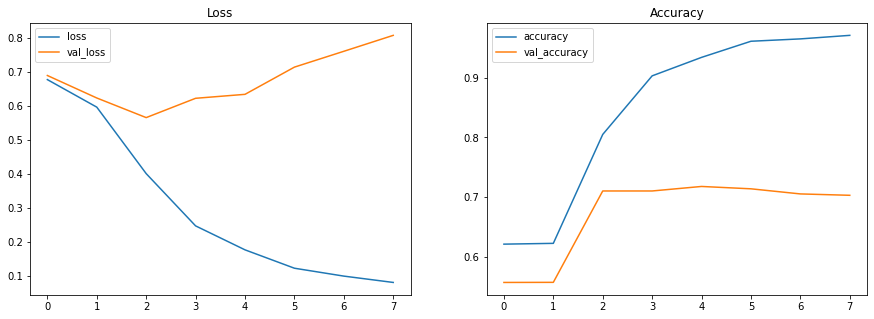

In [94]:
history_lstm_bi = fit_model(model_lstm_bi, verbose = 1)  
show_history(history_lstm_bi)

In [95]:
tf.random.set_seed(1)
model_lstm_multiple_bi = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length = maxlen),
    keras.layers.Bidirectional(keras.layers.LSTM(embedding_dim, return_sequences = True)),
    keras.layers.Bidirectional(keras.layers.LSTM(embedding_dim)),
    keras.layers.Dense(16, activation = 'relu'),
    keras.layers.Dense(1),
])

model_lstm_multiple_bi.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 33, 16)            112000    
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 33, 32)            4224      
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 32)                6272      
_________________________________________________________________
dense_34 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 17        
Total params: 123,041
Trainable params: 123,041
Non-trainable params: 0
_________________________________________________________________


loss: 0.0823 - val_loss: 0.6253
accuracy: 0.9770 - val_accuracy: 0.7127


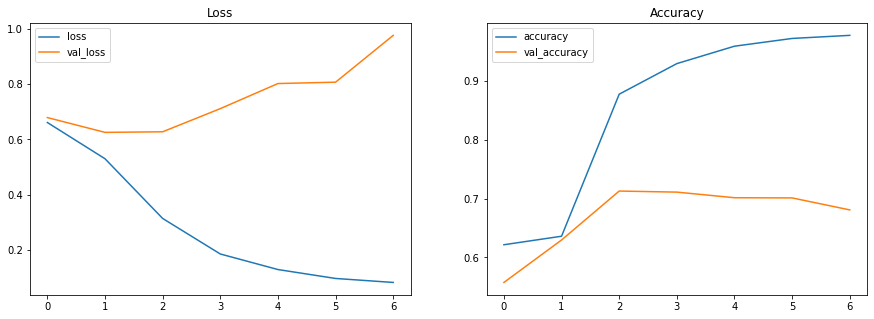

In [96]:
history_lstm_multiple_bi = fit_model(model_lstm_multiple_bi)  
show_history(history_lstm_multiple_bi)

## Final Model

In [99]:
final_model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length = maxlen),
    keras.layers.Bidirectional(keras.layers.LSTM(embedding_dim)),
    keras.layers.Dense(16, activation = 'relu'),
    keras.layers.Dense(1),
])

fit_model(final_model, validation_split = 0, epochs = 5)

# Predict on Test Data

In [100]:
predicted = final_model.predict(test_sequences)

In [104]:
print(predicted[:10])
test_targets = list(map(lambda x: 1 if x > 0 else 0, predicted))
test_targets[:10]

[[ 0.9523836]
 [ 1.2163361]
 [ 6.66016  ]
 [ 2.0975704]
 [ 6.358529 ]
 [ 4.246822 ]
 [-4.582698 ]
 [-2.7803013]
 [-4.2858844]
 [-3.0934145]]


[1, 1, 1, 1, 1, 1, 0, 0, 0, 0]

In [106]:
result_df = pd.DataFrame({'id': test_ids, 'target': test_targets})
result_df.to_csv('lstm_submission.csv', index = False)